In [1]:
import os
import pandas as pd
import seaborn as sns

filep = "./nfl-big-data-bowl-2026-prediction/train"

In [2]:
dict_columns = {}
for file in os.listdir(filep):
    print(pd.read_csv(filep+ "/" + file).columns)
    dict_columns[file] = pd.read_csv(filep+ "/" + file).columns.values

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
      dtype='object')
Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
      dtype='object')
Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 

In [3]:
dict_columns

{'input_2023_w01.csv': array(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
        'play_direction', 'absolute_yardline_number', 'player_name',
        'player_height', 'player_weight', 'player_birth_date',
        'player_position', 'player_side', 'player_role', 'x', 'y', 's',
        'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
       dtype=object),
 'input_2023_w02.csv': array(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
        'play_direction', 'absolute_yardline_number', 'player_name',
        'player_height', 'player_weight', 'player_birth_date',
        'player_position', 'player_side', 'player_role', 'x', 'y', 's',
        'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
       dtype=object),
 'input_2023_w03.csv': array(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
        'play_direction', 'absolute_yardline_number', 'player_name',
        'player_height', 'player_weight'

In [4]:


import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from pathlib import Path
import gc
import joblib
import os
from tqdm import tqdm



In [5]:
WEEKS = list(range(1, 19))
N_FOLDS = 5
RANDOM_STATE = 42

group_cols = ['game_id', 'play_id', 'nfl_id']
id_dataset = ['game_id', 'play_id', 'nfl_id', 'frame_id']

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 32,
    "max_depth": -1,
    #"feature_fraction": 0.85,
    #"bagging_fraction": 0.85,
    #"bagging_freq": 5,
    "n_estimators": 1000,
    "random_state": 42,
    "verbose": -1,
}

In [6]:

def load_weeks_parallel(week_nums, filep, max_workers=8):
    def load_week(w):
        inp = pd.read_csv(filep + "/" + f"input_2023_w{w:02d}.csv")
        out = pd.read_csv(filep + "/" + f"output_2023_w{w:02d}.csv")
        return w, inp, out

    inputs, outputs = [], []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(load_week, w): w for w in week_nums}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading weeks"):
            w, inp, out = future.result()
            inputs.append(inp)
            outputs.append(out)

    return pd.concat(inputs, ignore_index=True), pd.concat(outputs, ignore_index=True)

input_df, output_df = load_weeks_parallel(WEEKS, filep, max_workers=8)
print(f"Data loaded: {len(input_df)} input rows, {input_df['game_id'].nunique()} games")
print(f"Data loaded: {len(output_df)} output rows, {output_df['game_id'].nunique()} games")



Loading weeks: 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]


Data loaded: 4880579 input rows, 272 games
Data loaded: 562936 output rows, 272 games


In [7]:
def parse_height(h):
    try:
        if isinstance(h, str) and '-' in h:
            ft, inch = h.split('-')
            return float(ft) + float(inch) / 12.0
        return np.nan
    except:
        return np.nan


def create_features(df):
    df = df.copy()

    # Player height
    df['player_height_feet'] = df['player_height'].map(parse_height)

    if 1==0:
        # Speed & acceleration components
        df['dir_rad'] = np.deg2rad(df['dir'].fillna(0.0))
        df['velocity_x'] = df['s'] * np.cos(df['dir_rad'])
        df['velocity_y'] = df['s'] * np.sin(df['dir_rad'])
        df['acceleration_x'] = df['a'] * np.cos(df['dir_rad'])
        df['acceleration_y'] = df['a'] * np.sin(df['dir_rad'])

        # Orientation
        df['o_rad'] = np.deg2rad(df['o'].fillna(0.0))
        df['orientation_x'] = np.cos(df['o_rad'])
        df['orientation_y'] = np.sin(df['o_rad'])

        # Kinetic energy
        df['kinetic_energy'] = 0.5 * (df['player_weight'] * 0.453592) * ((df['s'] * 0.9144) ** 2)

        # Roles
        df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
        df['is_defense'] = (df['player_side'] == 'Defense').astype(int)
        df['is_receiver'] = df['player_role'].str.contains('Receiver|Targeted', case=False, na=False).astype(int)
        df['is_coverage'] = df['player_role'].str.contains('Coverage|Defensive', case=False, na=False).astype(int)
        df['is_passer'] = df['player_role'].str.contains('Passer', case=False, na=False).astype(int)
        df['is_rusher'] = df['player_role'].str.contains('Rusher', case=False, na=False).astype(int)

        # Field position
        df['field_x_norm'] = df['x'] / 120.0
        df['field_y_norm'] = df['y'] / 53.3
        df['dist_from_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
        df['dist_from_endzone'] = df['absolute_yardline_number']
        df['distance_to_sideline'] = df['dist_from_sideline']
        df['distance_to_endzone'] = df['dist_from_endzone']

        # Ball interaction
        df['ball_direction_x'] = df['ball_land_x'] - df['x']
        df['ball_direction_y'] = df['ball_land_y'] - df['y']
        df['distance_to_ball'] = np.sqrt(df['ball_direction_x']**2 + df['ball_direction_y']**2)
        df['angle_to_ball'] = np.arctan2(df['ball_direction_y'], df['ball_direction_x'])
    #df['closing_speed'] = (
    #    (df['velocity_x'] * df['ball_direction_x'] + df['velocity_y'] * df['ball_direction_y'])
    #    / df['distance_to_ball'].replace(0, np.nan)
    #).fillna(0.0)

    # Target Alignment Features
    #if 'ball_direction_x' in df.columns:
    if 0==1:
        df['velocity_alignment'] = (
            df['velocity_x'] * df['ball_direction_x'] +
            df['velocity_y'] * df['ball_direction_y']
        )
        df['velocity_perpendicular'] = (
            df['velocity_x'] * (-df['ball_direction_y']) +
            df['velocity_y'] * df['ball_direction_x']
        )
        if 'acceleration_x' in df.columns:
            df['accel_alignment'] = (
                df['acceleration_x'] * df['ball_direction_x'] +
                df['acceleration_y'] * df['ball_direction_y']
            )
    
    # Sort by time for sequential features
    df = df.sort_values(id_dataset)
    group = df.groupby(group_cols)

     # Role-Specific Features
    #if 'is_receiver' in df.columns and 'velocity_alignment' in df.columns:
    #    df['receiver_optimality'] = df['is_receiver'] * df['velocity_alignment']
    #    df['receiver_deviation'] = df['is_receiver'] * np.abs(df.get('velocity_perpendicular', 0))
    #if 'is_coverage' in df.columns and 'closing_speed' in df.columns:
    #    df['defender_closing_speed'] = df['is_coverage'] * df['closing_speed']

    # Lags
    for lag in [1, 2]:#, 3, 5]:
        for c in ['x', 'y']:#, 'velocity_x', 'velocity_y', 's']:
            df[f"{c}_lag{lag}"] = group[c].shift(lag)

    # EMA (fixed + optimized)
    #for alpha in [0.1, 0.3, 0.5]:
    #    df[f'velocity_x_ema_{alpha}'] = (
    #        df.groupby(group_cols)['velocity_x']
    #        .transform(lambda s: s.ewm(alpha=alpha, adjust=False).mean())
    #    )
    #    df[f'velocity_y_ema_{alpha}'] = (
    #        df.groupby(group_cols)['velocity_y']
    #        .transform(lambda s: s.ewm(alpha=alpha, adjust=False).mean())
    #    )

    # Rolling features
    if 1==0:
        for c in ['velocity_x', 'velocity_y']:#, 's', 'a']:
            df[f'{c}_roll5'] = (
                group[c].rolling(5, min_periods=1)
                .mean()
                .reset_index(level=[0, 1, 2], drop=True)
            )
            df[f'{c}_std5'] = (
                group[c].rolling(5, min_periods=1)
                .std()
                .reset_index(level=[0, 1, 2], drop=True)
                .fillna(0)
            )

    return df

input_df = create_features(input_df)
print(f"Features created: {input_df.shape[1]} columns")

input_df = input_df[input_df["player_to_predict"]==True]

Features created: 28 columns


([0, 1], [Text(0, 0, 'Targeted Receiver'), Text(1, 0, 'Defensive Coverage')])

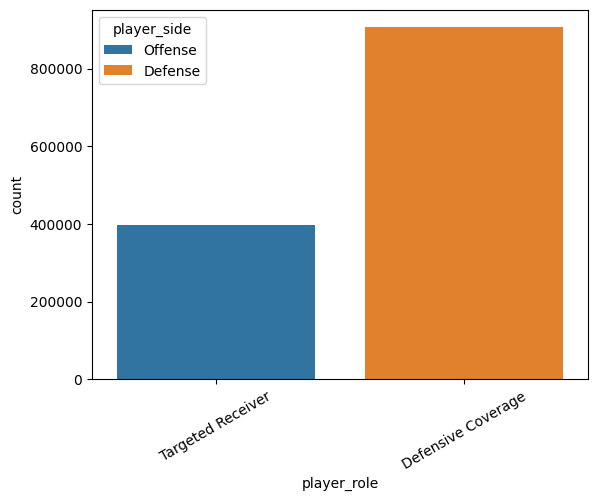

In [8]:
import matplotlib.pyplot as plt
g = sns.countplot(data=input_df, x="player_role", hue="player_side")

plt.xticks(rotation=30)

In [9]:
input_df = input_df.round(3)

In [10]:
#input_df.to_csv("featured.csv")
#input_df.head()

In [11]:
#input_df = pd.read_csv("featured.csv")

In [12]:
output_df.head()


,game_id,play_id,nfl_id,frame_id,x,y
0,2023101900,78,44851,1,45.00,39.84
1,2023101900,78,44851,2,44.95,40.28
2,2023101900,78,44851,3,44.86,40.74
3,2023101900,78,44851,4,44.74,41.24
4,2023101900,78,44851,5,44.59,41.77


In [13]:
test = pd.read_csv("nfl-big-data-bowl-2026-prediction/test.csv")

In [14]:
test_input = pd.read_csv("nfl-big-data-bowl-2026-prediction/test_input.csv")
test_input.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2024120805,74,False,52518,1,left,95,Darnay Holmes,5-10,198,...,Defensive Coverage,90.85,17.17,0.35,0.78,218.39,81.52,11,90.379997,46.470001
1,2024120805,74,False,52518,2,left,95,Darnay Holmes,5-10,198,...,Defensive Coverage,90.83,17.11,0.62,1.20,204.64,81.52,11,90.379997,46.470001
2,2024120805,74,False,52518,3,left,95,Darnay Holmes,5-10,198,...,Defensive Coverage,90.80,17.03,0.87,1.44,200.53,81.52,11,90.379997,46.470001
3,2024120805,74,False,52518,4,left,95,Darnay Holmes,5-10,198,...,Defensive Coverage,90.76,16.91,1.22,1.87,197.16,81.52,11,90.379997,46.470001
4,2024120805,74,False,52518,5,left,95,Darnay Holmes,5-10,198,...,Defensive Coverage,90.72,16.77,1.52,2.11,195.24,83.75,11,90.379997,46.470001


In [15]:
set1 = set(test_input.game_id.values)
set2 = set(test.game_id.values)
print(set1, set2)
set2.difference(set1)

{np.int64(2025010515), np.int64(2024120805), np.int64(2024121502)} {np.int64(2025010515), np.int64(2024120805), np.int64(2024121502)}


set()

In [16]:
print(input_df.shape)
input_df.dropna(inplace=True)
print(input_df.shape)

(1303440, 28)
(1211350, 28)


In [17]:
input_df.select_dtypes(include='object')
#input_df.drop(["player_name", "player_birth_date"],inplace=True, axis=1)
#input_df.drop(["player_height"],inplace=True, axis=1)

,play_direction,player_name,player_height,player_birth_date,player_position,player_side,player_role
1040273,right,Josh Reynolds,6-3,1995-02-16,WR,Offense,Targeted Receiver
1040274,right,Josh Reynolds,6-3,1995-02-16,WR,Offense,Targeted Receiver
1040275,right,Josh Reynolds,6-3,1995-02-16,WR,Offense,Targeted Receiver
1040276,right,Josh Reynolds,6-3,1995-02-16,WR,Offense,Targeted Receiver
1040277,right,Josh Reynolds,6-3,1995-02-16,WR,Offense,Targeted Receiver
...,...,...,...,...,...,...,...
4880277,left,Dane Jackson,5-11,1996-11-29,CB,Defense,Defensive Coverage
4880278,left,Dane Jackson,5-11,1996-11-29,CB,Defense,Defensive Coverage
4880279,left,Dane Jackson,5-11,1996-11-29,CB,Defense,Defensive Coverage
4880280,left,Dane Jackson,5-11,1996-11-29,CB,Defense,Defensive Coverage


In [18]:
useless_cols = ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'player_name',
       'player_height', 'player_weight',
       'player_side', 'player_role', 
       'dir', 'o', 'num_frames_output', 
       ]

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#input_df = input_df[0:1000]


y = input_df[["x", "y"]]

X = input_df.copy()

problem_features= ['player_name', 'player_height', 'player_birth_date']

X.drop(problem_features, axis=1, inplace=True)
X.drop(["x","y"], axis=1, inplace=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle=False)

In [21]:
#X_train[['play_direction', 'player_name', 'player_height', 'player_birth_date', 'player_position',\
#         	'player_side', 'player_role', 'is_coverage', 'is_passer', 'is_rusher']]

In [22]:
X_train.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_weight',
       'player_position', 'player_side', 'player_role', 's', 'a', 'dir', 'o',
       'num_frames_output', 'ball_land_x', 'ball_land_y', 'player_height_feet',
       'x_lag1', 'y_lag1', 'x_lag2', 'y_lag2'],
      dtype='object')

In [23]:
X_test.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_weight',
       'player_position', 'player_side', 'player_role', 's', 'a', 'dir', 'o',
       'num_frames_output', 'ball_land_x', 'ball_land_y', 'player_height_feet',
       'x_lag1', 'y_lag1', 'x_lag2', 'y_lag2'],
      dtype='object')

In [24]:
categorical_features =  test.select_dtypes(include="object")
categorical_features

""
0
1
2
3
4
...
5832
5833
5834
5835


In [25]:
categorical_features =  X_train.select_dtypes(include="object").columns.tolist()
print(categorical_features)

['play_direction', 'player_position', 'player_side', 'player_role']


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


categorical_transformer = OneHotEncoder(handle_unknown="ignore")
#categorical_features = ['play_direction', 'player_position',\
#         	'player_side', 'player_role', 'is_coverage', 'is_passer', 'is_rusher']

categorical_features =  X_train.select_dtypes(include="object").columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
)




mod1 = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, random_state=0)
)

pipe = Pipeline([('preproc', preprocessor),
    ("mod", mod1)])

In [27]:
y_train

,x,y
1040273,41.05,12.18
1040274,41.07,12.20
1040275,41.11,12.22
1040276,41.20,12.26
1040277,41.33,12.33
...,...,...
3898317,75.09,35.82
3898318,74.86,35.86
3898319,74.59,35.90
3898320,74.26,35.93


In [28]:
X_train

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_weight,player_position,player_side,...,dir,o,num_frames_output,ball_land_x,ball_land_y,player_height_feet,x_lag1,y_lag1,x_lag2,y_lag2
1040273,2023090700,101,True,44930,3,right,42,196,WR,Offense,...,65.03,83.33,21,63.26,-0.22,6.25,41.03,12.17,41.03,12.17
1040274,2023090700,101,True,44930,4,right,42,196,WR,Offense,...,56.06,84.29,21,63.26,-0.22,6.25,41.05,12.18,41.03,12.17
1040275,2023090700,101,True,44930,5,right,42,196,WR,Offense,...,59.41,88.21,21,63.26,-0.22,6.25,41.07,12.20,41.05,12.18
1040276,2023090700,101,True,44930,6,right,42,196,WR,Offense,...,61.83,83.40,21,63.26,-0.22,6.25,41.11,12.22,41.07,12.20
1040277,2023090700,101,True,44930,7,right,42,196,WR,Offense,...,63.45,78.78,21,63.26,-0.22,6.25,41.20,12.26,41.11,12.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3898317,2023121704,2024,True,55937,9,left,78,189,CB,Defense,...,285.12,159.39,10,66.05,27.01,6.00,75.28,35.77,75.42,35.72
3898318,2023121704,2024,True,55937,10,left,78,189,CB,Defense,...,280.65,165.59,10,66.05,27.01,6.00,75.09,35.82,75.28,35.77
3898319,2023121704,2024,True,55937,11,left,78,189,CB,Defense,...,277.63,171.10,10,66.05,27.01,6.00,74.86,35.86,75.09,35.82
3898320,2023121704,2024,True,55937,12,left,78,189,CB,Defense,...,274.96,177.37,10,66.05,27.01,6.00,74.59,35.90,74.86,35.86


In [ ]:
#With features reduced to the max & only players of interest, the runtime is still 74 minutes.
pipe.fit(X_train, y_train)

,steps,"[('preproc', ...), ('mod', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
import pickle as pkl

with open('temppipe.pkl', 'wb') as file:
    pkl.dump(pipe, file)

In [37]:
y_pred = pipe.predict(X_test)
y_pred

array([[73.5183, 35.9649],
       [73.0754, 35.9904],
       [72.6044, 35.9809],
       ...,
       [44.7185, 13.6404],
       [44.5079, 13.3435],
       [44.327 , 13.0725]], shape=(242270, 2))

In [38]:
y_test[["x", "y"]]

,x,y
3898322,73.50,35.97
3898323,73.06,35.98
3898324,72.59,35.98
3898325,72.08,35.98
3898326,71.54,35.99
...,...,...
4880277,45.30,14.19
4880278,45.02,13.92
4880279,44.77,13.64
4880280,44.56,13.36


In [39]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(0.02393939407292632)

In [40]:
feature_names = pipe.named_steps['preproc'].get_feature_names_out()
feature_names

array(['cat__play_direction_left', 'cat__play_direction_right',
       'cat__player_position_CB', 'cat__player_position_DE',
       'cat__player_position_DT', 'cat__player_position_FB',
       'cat__player_position_FS', 'cat__player_position_ILB',
       'cat__player_position_MLB', 'cat__player_position_NT',
       'cat__player_position_OLB', 'cat__player_position_QB',
       'cat__player_position_RB', 'cat__player_position_S',
       'cat__player_position_SS', 'cat__player_position_T',
       'cat__player_position_TE', 'cat__player_position_WR',
       'cat__player_side_Defense', 'cat__player_side_Offense',
       'cat__player_role_Defensive Coverage',
       'cat__player_role_Targeted Receiver', 'remainder__game_id',
       'remainder__play_id', 'remainder__player_to_predict',
       'remainder__nfl_id', 'remainder__frame_id',
       'remainder__absolute_yardline_number', 'remainder__player_weight',
       'remainder__s', 'remainder__a', 'remainder__dir', 'remainder__o',
       'rema

In [41]:
#this takes too long, omitted.

#from sklearn.inspection import permutation_importance
#result = permutation_importance(
#    pipe, X_test, y_test,
#    n_jobs=-1
#)


In [42]:
#sorted_idx = result.importances_mean.argsort()[-20:]
        

#fig, ax = plt.subplots(figsize=(12, 10))
#ax.boxplot(result.importances[sorted_idx].T,
#           vert=False, labels=X_test.columns[sorted_idx])
#ax.set_title("Permutation Importances (test set)")
#fig.tight_layout()
#plt.show()

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

numeric_features = [col for col in X.columns if col not in categorical_features]

categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])



scaler = StandardScaler()

preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', categorical, categorical_features),
        ('num', numeric, numeric_features)
    ],
    remainder='passthrough'
)




mod2 = MultiOutputRegressor(
        KNeighborsRegressor(n_neighbors=5)
)

pipe2 = Pipeline([('preproc', preprocessor2),("mod", mod2)])

In [44]:
pipe2.fit(X_train, y_train)


,steps,"[('preproc', ...), ('mod', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
y_pred = pipe2.predict(X_test)

In [46]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(5.340018778213589)

C:\Users\volte\AppData\Local\Temp\ipykernel_24680\3174404298.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T,


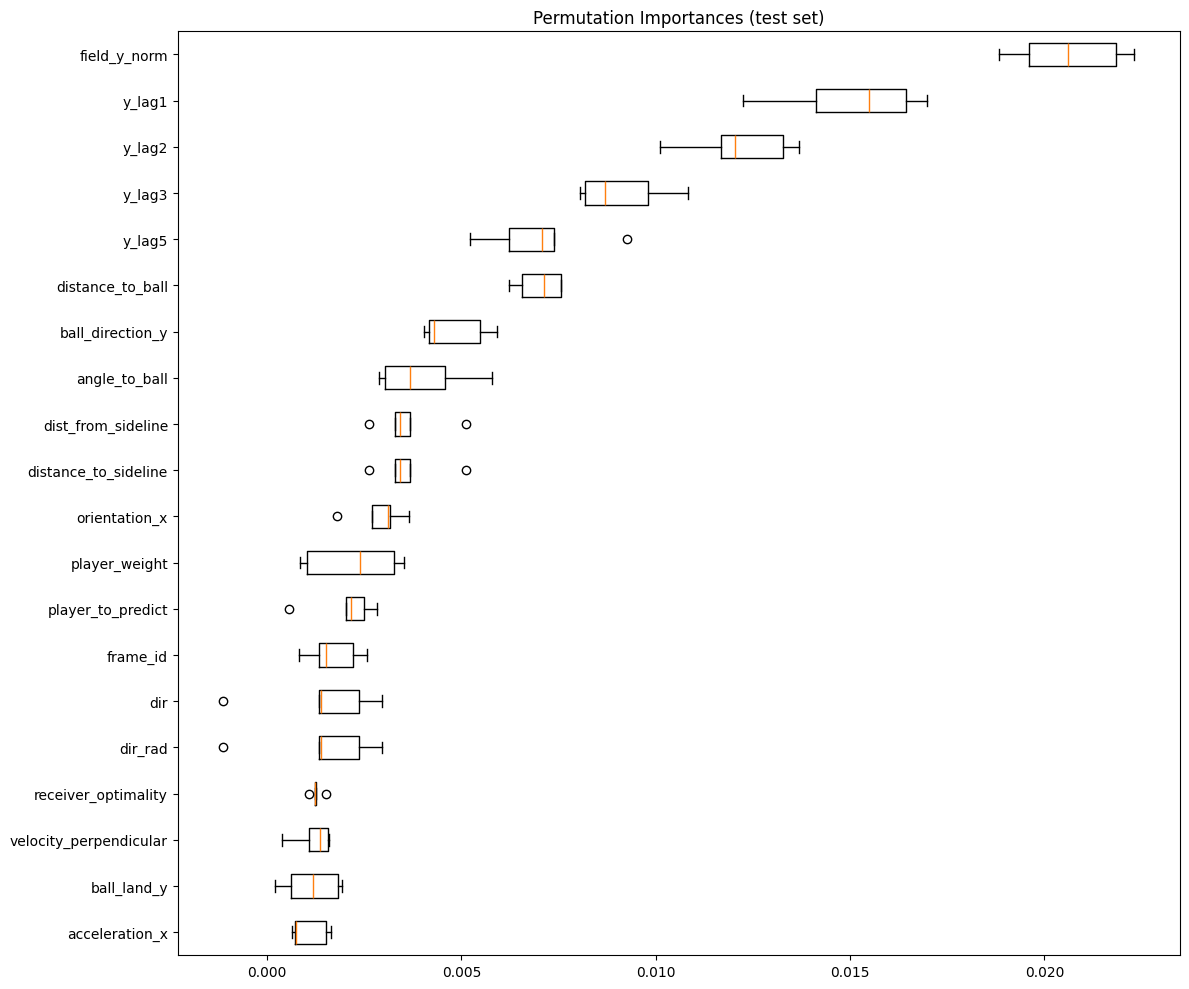

In [ ]:
#Takes too long, omitted

#result = permutation_importance(
#    pipe2, X_test, y_test,
#    n_jobs=-1
#)
#sorted_idx = result.importances_mean.argsort()[-20:]
        

#fig, ax = plt.subplots(figsize=(12, 10))
#ax.boxplot(result.importances[sorted_idx].T,
#           vert=False, labels=X_test.columns[sorted_idx])
#ax.set_title("Permutation Importances (test set)")
#fig.tight_layout()
#plt.show()

## Below a group k fold example

Omitted for now because runitme is until heat death of the universe

In [47]:
from sklearn.model_selection import GroupKFold




gkf = GroupKFold(n_splits=5)
metrics = []
models_dx, models_dy = [], []
Xc = pd.concat([X_train, X_test])

yc = pd.concat([y_train, y_test])
yc.head()

,x,y
1040273,41.05,12.18
1040274,41.07,12.20
1040275,41.11,12.22
1040276,41.20,12.26
1040277,41.33,12.33


In [ ]:
groups = Xc["game_id"]
groups_c = groups.astype(np.float32)




for fold, (tr_idx, va_idx) in enumerate(gkf.split(Xc, yc, groups_c)):
    print(f"\nFold {fold+1}/5")

    Xtr, Xva = Xc.iloc[tr_idx], Xc.iloc[va_idx]
    ydx_tr, ydx_va = y_dx_c.iloc[tr_idx], y_dx_c.iloc[va_idx]
    ydy_tr, ydy_va = y_dy_c.iloc[tr_idx], y_dy_c.iloc[va_idx]

    y_train = pd.concat([ydx_tr, ydy_tr], axis=1)

    y_test = pd.concat([ydx_va, ydy_va], axis=1)

    mod2.fit(
        Xtr, y_train,
        #eval_set=[(Xva, ydx_va)],
        #eval_metric="rmse",
        #callbacks=callbacks
    )
    #best_it_dx = m_dx.best_iteration_ if getattr(m_dx, "best_iteration_", None) else lgb_params["n_estimators"]
    #p_dx = m_dx.predict(Xva, num_iteration=best_it_dx)
    #models_dx.append(m_dx)

    # dy

    y_pred = mod2.predict(Xva)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    metrics.append(rmse)
    print(f"rmse: {rmse}")

metrics = np.array(metrics)


ValueError: Cannot have number of splits n_splits=5 greater than the number of groups: 1.